In [43]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.io import loadmat
import math
import utils
grader = utils.Grader()
%matplotlib inline

In [44]:
input_layer_size = 400
# 10 labels, from 1 to 10 (mapped "0" to label 10)
num_labels = 10
data = loadmat(os.path.join('data', 'ex3data1.mat'))
X, y = data['X'], data['y']
# set the zero digit to 0, rather than its mapped 10 in the dataset
y[y == 0] = 0
m = y.size



In [45]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


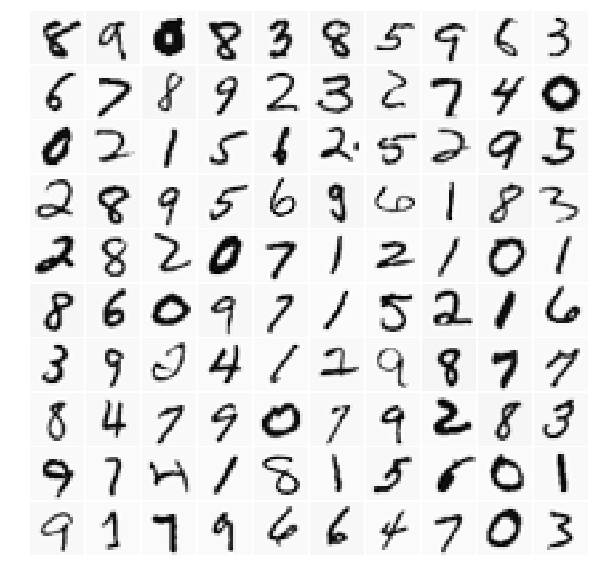

In [46]:
indices = np.random.permutation(m)
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [47]:
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

In [48]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [49]:
def lrCostFunction(theta, X, y, lambda_t):
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    J = 0
    
    hypothesis = sigmoid(np.dot(X, theta))
    error = (y * np.log(hypothesis) + ((1-y)*np.log(1-hypothesis)))
    
    J = - (1 / m) * np.sum(error)
    reg = (lambda_t / (2 * m)) * sum((theta[1:] ** 2))
    J = J + reg
    grad = 1/m * np.dot(X.T, (hypothesis - y))
    grad[1:] = grad[1:] + (lambda_t / m) * theta[1:]
    
    return J, grad

In [50]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)
print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [51]:
# grader[1] = lrCostFunction
# grader.grade()

In [52]:
def oneVsAll(X, y, num_labels, lambda_):
    options= {'maxiter': 50}
    m, n = X.shape
    theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis = 1)
    
    for i in range (num_labels):
        y_bools = (y == (i+1)).astype(int).reshape([m,])
        res = optimize.minimize(lrCostFunction,
                                   theta[i],
                                   (X, y_bools, lambda_),
                                    jac=True,
                                    method='TNC',
                                    options=options)
        theta[i] = res.x
    print(theta.shape)
    return theta

In [53]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

(10, 401)


In [54]:
# grader[2] = oneVsAll
# grader.grade()

In [55]:
def predictOneVsAll(all_theta, X):
    p = np.zeros([X.shape[0], 1])
    
    m = X.shape[0] # number of examples
    num_labels = all_theta.shape[0] # number of categories

    # Add column of ones to X for bias
    X = np.column_stack((np.ones(m), X))
    
    z = np.dot(X, all_theta.T)
    p = np.argmax(sigmoid(z), axis=1) + 1 # +1 to change 0-9 into 1-10
    p = np.reshape(p, (m,1)) # to make compatible with y.shape
    
    return p

In [56]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 95.36%


In [57]:
def displayPredictions(X, prediction):

    m = X.shape[0] # number of images
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    
    n = X.shape[1] # total number of pixels per image
    image_side = int(math.sqrt(n))
    
    plt.figure(figsize=(8,8))
    
    for i in range(m):
        # Plot image
        image = X[i]
        image = np.reshape(image, (image_side, image_side), order='F')
        plt.subplot(display_rows, display_cols, i+1)
        
        plt.imshow(image, cmap='Greys')
        plt.axis('off')
        
        # Make and print prediction for image
        rand_image = X[i]
        rand_image = rand_image.reshape([1,400])
       
        pred = prediction(all_theta, rand_image)
        pred_int = int(pred)
        if pred_int==10: # Fix the fact that 0 is mapped to 10
            pred_int=0
    
        pred_str = 'Prediction:' + str(pred_int)
        plt.text(0,1.4, pred_str, color='b')
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Display a few predictions, just for fun:


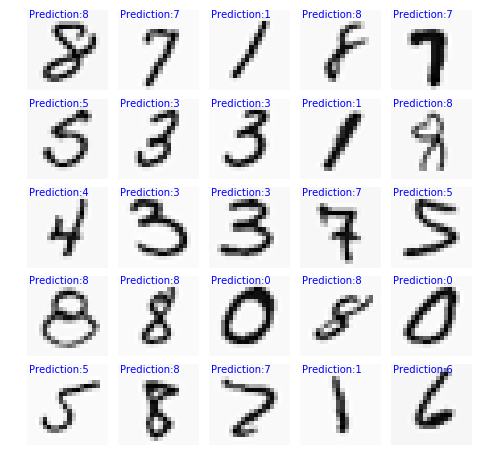

In [58]:
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:25], :]
print('Display a few predictions, just for fun:')
displayPredictions(sel, predictOneVsAll)

In [59]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10 # 10 labels from 0 to 9

weights = loadmat(os.path.join('Data', 'ex3weights.mat'))
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
# Theta2 = np.roll(Theta2, 1, axis=0)
print(X.shape)
print(Theta1.shape)
print(Theta2.shape)

(5000, 400)
(25, 401)
(10, 26)


In [60]:
def predict(theta, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m, 1)), X))
    a1 = sigmoid(np.dot(X, theta[0].T))
    a1 = np.hstack((np.ones((m, 1)), a1)) # Adding bias unit
    a2 = sigmoid(np.dot(a1, theta[1].T)) # output layer
    return np.argmax(a2, axis=1) + 1

In [61]:
theta = np.array([Theta1, Theta2])

pred2 = predict(theta, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")


Training Set Accuracy: 97.52 %
